In [67]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import eigh
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_absolute_error, mean_squared_error

## Part: 1.2 

In [68]:
# List of 30 Dow Jones Industrial Average tickers
dow_tickers = [
    "AAPL","AMGN","AXP","BA","CAT","CRM","CSCO","CVX","DIS","DOW",
    "GS","HD","HON","IBM","INTC","JNJ","JPM","KO","MCD","MMM",
    "MRK","MSFT","NKE","PG","TRV","UNH","V","VZ","AMZN","WMT"
]

# Minimum 2 years of data
data = yf.download(dow_tickers, start="2023-01-01", end=None)["Close"] # Download closing prices from 2023-01-01 to present

data.head()

C:\Users\mitch\AppData\Local\Temp\ipykernel_32728\1280975853.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(dow_tickers, start="2023-01-01", end=None)["Close"] # Download closing prices from 2023-01-01 to present
[*********************100%***********************]  30 of 30 completed


Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,123.211197,237.729874,85.820000,141.733627,195.389999,226.965149,133.376984,43.915386,153.387268,87.511131,...,91.597702,102.296082,233.985641,112.612129,140.514465,177.473801,494.280914,202.755203,32.782887,46.241451
2023-01-04,124.482025,240.219406,85.139999,145.028412,203.639999,229.321472,138.136902,43.906155,151.756302,90.471771,...,93.602127,103.161285,223.750381,114.944992,141.126297,177.578094,480.805145,207.858521,33.608185,46.292973
2023-01-05,123.161949,242.463562,83.120003,141.557861,204.990005,228.295334,134.920761,43.287498,154.489243,90.412750,...,91.964172,104.597145,217.118881,114.385475,139.374161,177.881622,466.947968,206.392059,34.073940,46.135193
2023-01-06,127.693588,250.041153,86.080002,145.173416,213.000000,236.447372,139.047333,44.617149,155.652939,92.379959,...,94.776367,105.701660,219.677750,118.093384,142.693054,183.875809,466.986115,212.883652,34.474323,47.265465
2023-01-09,128.215698,245.425491,87.360001,145.395782,208.570007,234.319092,145.568741,44.857235,154.436310,93.216019,...,94.828705,101.596550,221.816605,118.396843,140.950150,179.370667,467.043274,213.714645,34.335720,46.676174


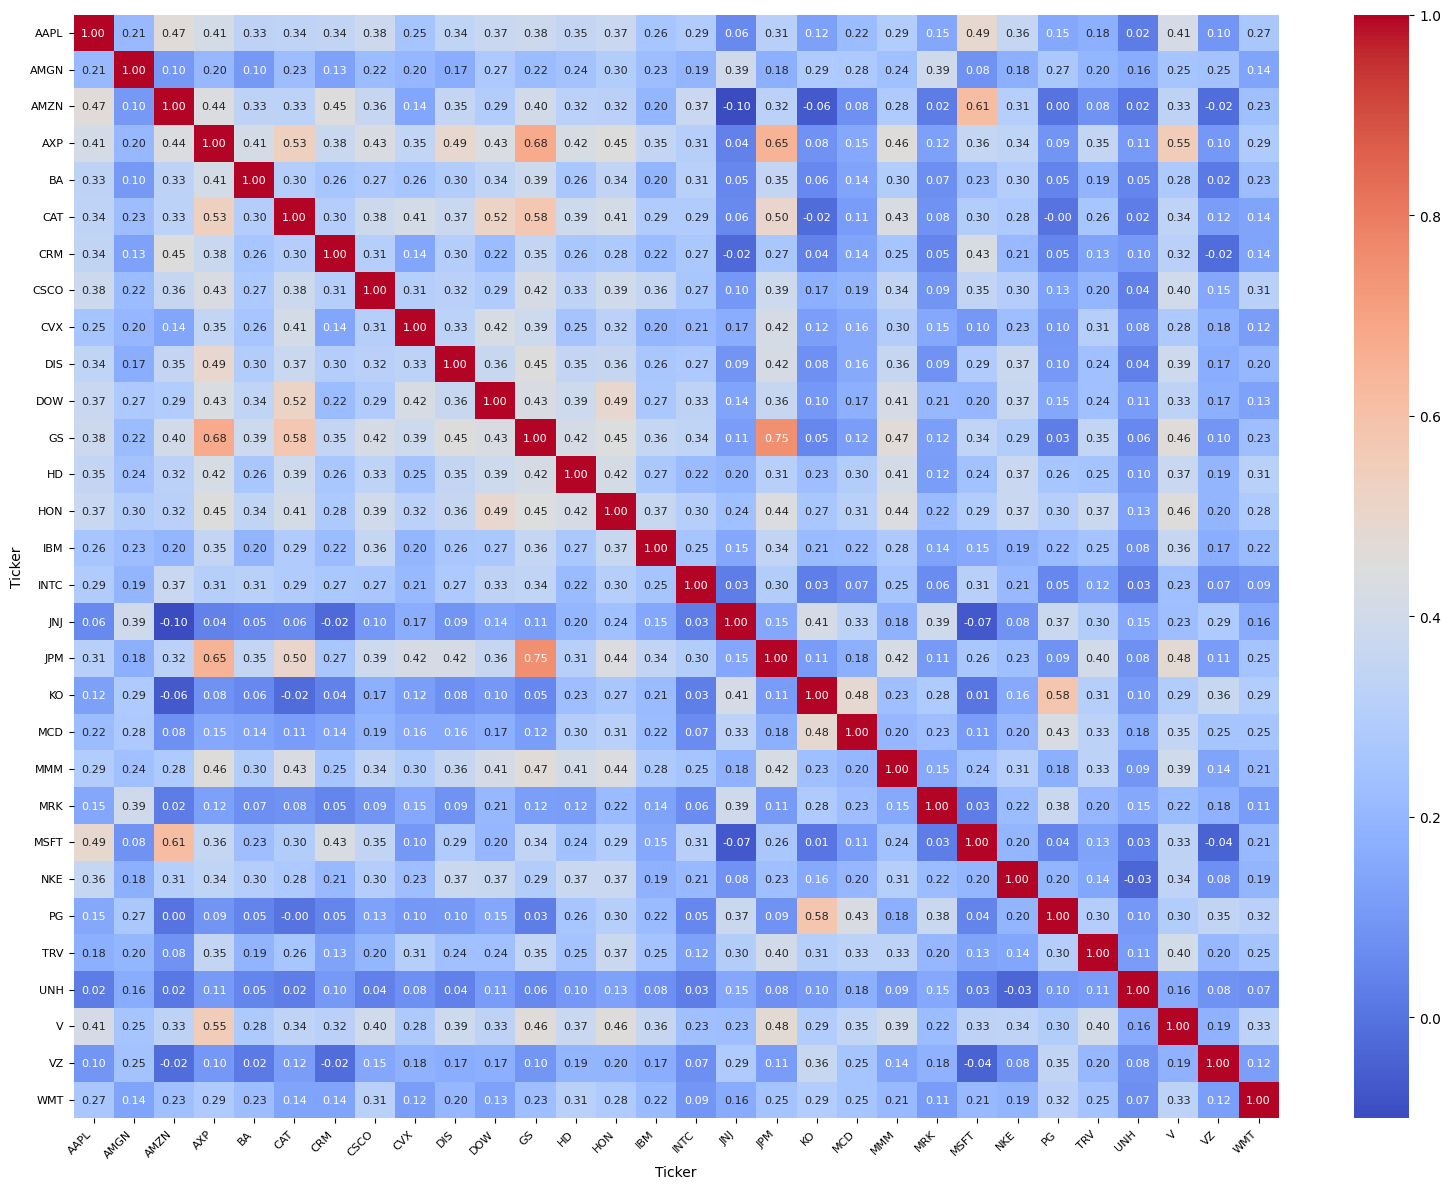

In [69]:
log_returns = np.log(data / data.shift(1)) # Compute daily log returns 
log_returns = log_returns.iloc[1:] # Remove NaN row which is the first row

corr_matrix = log_returns.corr() # Compute Pearson correlation matrix

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(16,12))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size":8}
)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

## Part 1.3

Explained variance ratio for first 5 PCs:
[0.28693436 0.10257321 0.05240714 0.04068647 0.03705615]


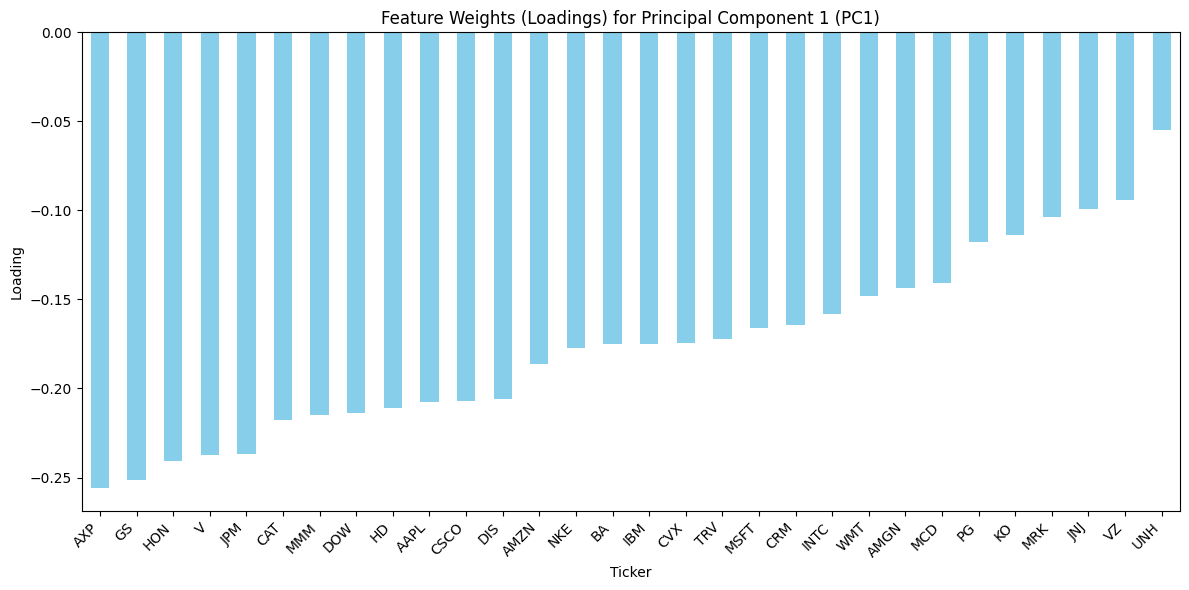

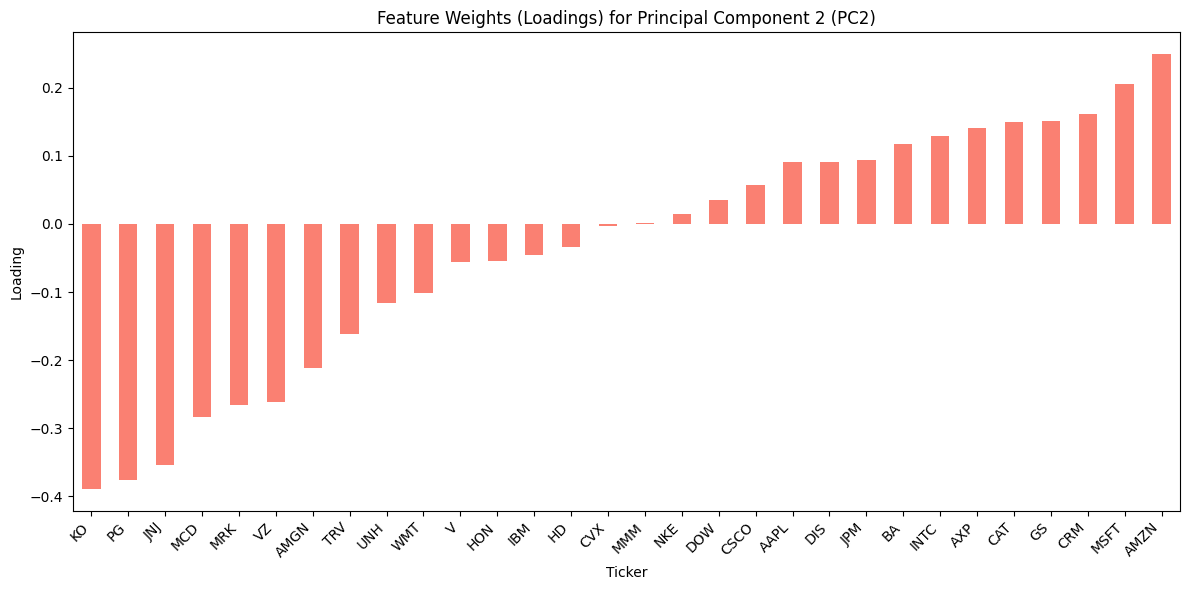

In [70]:
# Eigendecomposition of the correlation matrix
eigenvalues, eigenvectors = eigh(corr_matrix)  # eigh returns them in ascending order
# Reverse to descending order for standard PCA convention
eigenvalues = eigenvalues[::-1]
eigenvectors = eigenvectors[:, ::-1]

# Create a DataFrame for easier handling
loadings = pd.DataFrame(eigenvectors, index=corr_matrix.columns, columns=[f'PC{i+1}' for i in range(len(corr_matrix))])

# Display explained variance
explained_variance_ratio = eigenvalues / eigenvalues.sum()
print("Explained variance ratio for first 5 PCs:")
print(explained_variance_ratio[:5])

# Plot loadings for PC1
plt.figure(figsize=(12,6))
loadings['PC1'].sort_values().plot(kind='bar', color='skyblue')
plt.title("Feature Weights (Loadings) for Principal Component 1 (PC1)")
plt.ylabel("Loading")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot loadings for PC2
plt.figure(figsize=(12,6))
loadings['PC2'].sort_values().plot(kind='bar', color='salmon')
plt.title("Feature Weights (Loadings) for Principal Component 2 (PC2)")
plt.ylabel("Loading")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Part 1.4

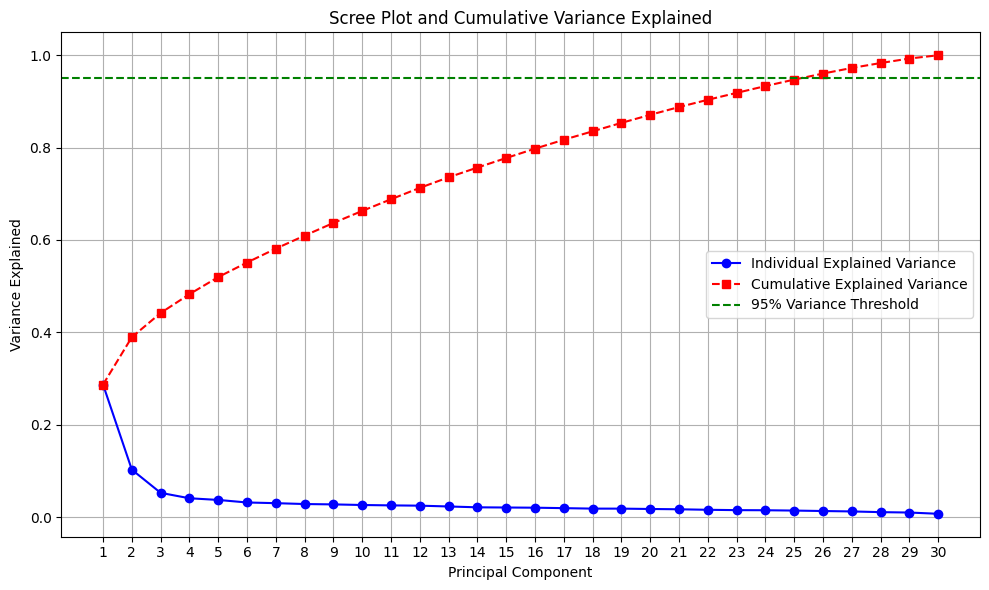

Number of principal components required to preserve 95% variance: 26


In [71]:
# Explained variance ratio (already partially computed)
explained_variance_ratio = eigenvalues / eigenvalues.sum()


# Scree plot
plt.figure(figsize=(10,6))
plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, 'o-', color='blue', label='Individual Explained Variance')
plt.plot(range(1, len(explained_variance_ratio)+1), np.cumsum(explained_variance_ratio), 's--', color='red', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='green', linestyle='--', label='95% Variance Threshold')
plt.xticks(range(1, len(explained_variance_ratio)+1))
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Scree Plot and Cumulative Variance Explained")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Determine k for 95% cumulative variance
k_95 = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1
print(f"Number of principal components required to preserve 95% variance: {k_95}")

## Part 2.2

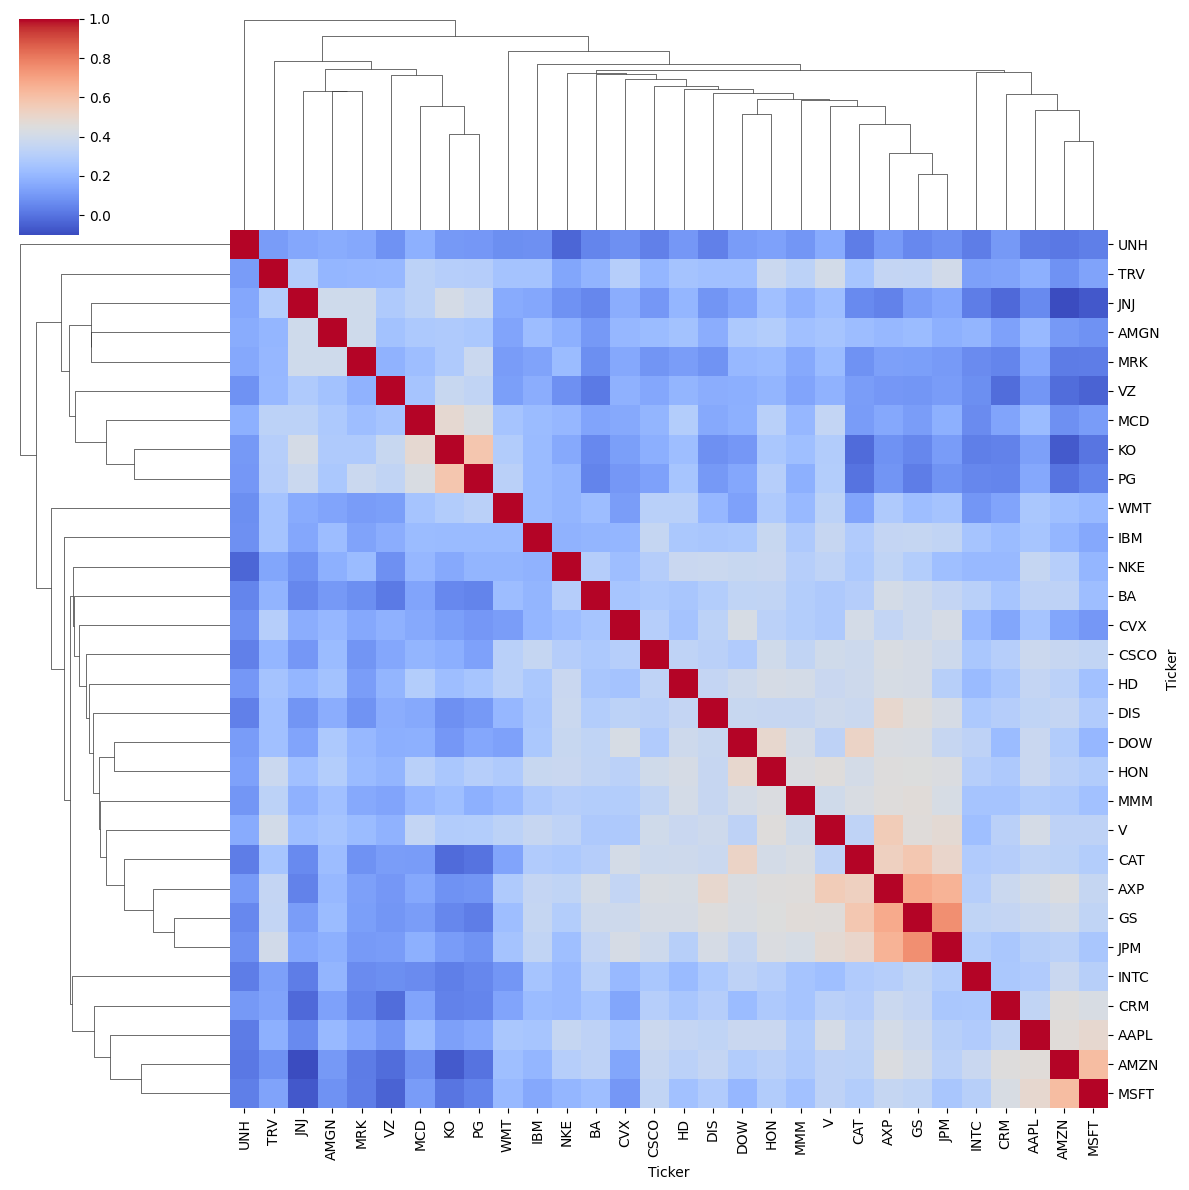


Block 1 Stocks: ['AMGN', 'JNJ', 'KO', 'MCD', 'MRK', 'PG', 'TRV', 'VZ']
Block 2 Stocks: ['AAPL', 'AMZN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JPM', 'MMM', 'MSFT', 'NKE', 'V']
Block 3 Stocks: ['WMT']
Block 3 Stocks: ['UNH']


In [72]:
# Convert correlation matrix to a distance matrix
dist_matrix = 1 - corr_matrix
condensed_dist = squareform(dist_matrix, checks=False)

# Perform hierarchical clustering using average linkage
Z = sch.linkage(condensed_dist, method="average")

# Plot the clustered heatmap
cg = sns.clustermap(
    corr_matrix,
    row_linkage=Z,
    col_linkage=Z,
    cmap="coolwarm",
    figsize=(12, 12)
    
)
plt.show()

# Assign cluster labels (three main blocks)
cluster_labels = sch.fcluster(Z, t=4, criterion="maxclust")

# Create DataFrame for grouping tickers by cluster
clusters_df = pd.DataFrame({
    "Ticker": corr_matrix.index,
    "Cluster": cluster_labels
})

# Identify each of the three diagonal blocks
block1 = clusters_df[clusters_df["Cluster"] == 1]["Ticker"].tolist()
block2 = clusters_df[clusters_df["Cluster"] == 2]["Ticker"].tolist()
block3 = clusters_df[clusters_df["Cluster"] == 3]["Ticker"].tolist()
block4 = clusters_df[clusters_df["Cluster"] == 4]["Ticker"].tolist()

print("\nBlock 1 Stocks:", block1)
print("Block 2 Stocks:", block2)
print("Block 3 Stocks:", block3)
print("Block 3 Stocks:", block4)

## Part 2.4

In [73]:
distance_matrix = 1 - corr_matrix
dist_array = squareform(distance_matrix.values, checks=False)

# Hierarchical clustering (average linkage)
Z = linkage(dist_array, method='average')

# Form four clusters
cluster_labels = fcluster(Z, t=4, criterion='maxclust')

# Organize results
clusters = {}
for ticker, label in zip(corr_matrix.columns, cluster_labels):
    clusters.setdefault(label, []).append(ticker)

clean_clusters = {int(k): v for k, v in clusters.items()}


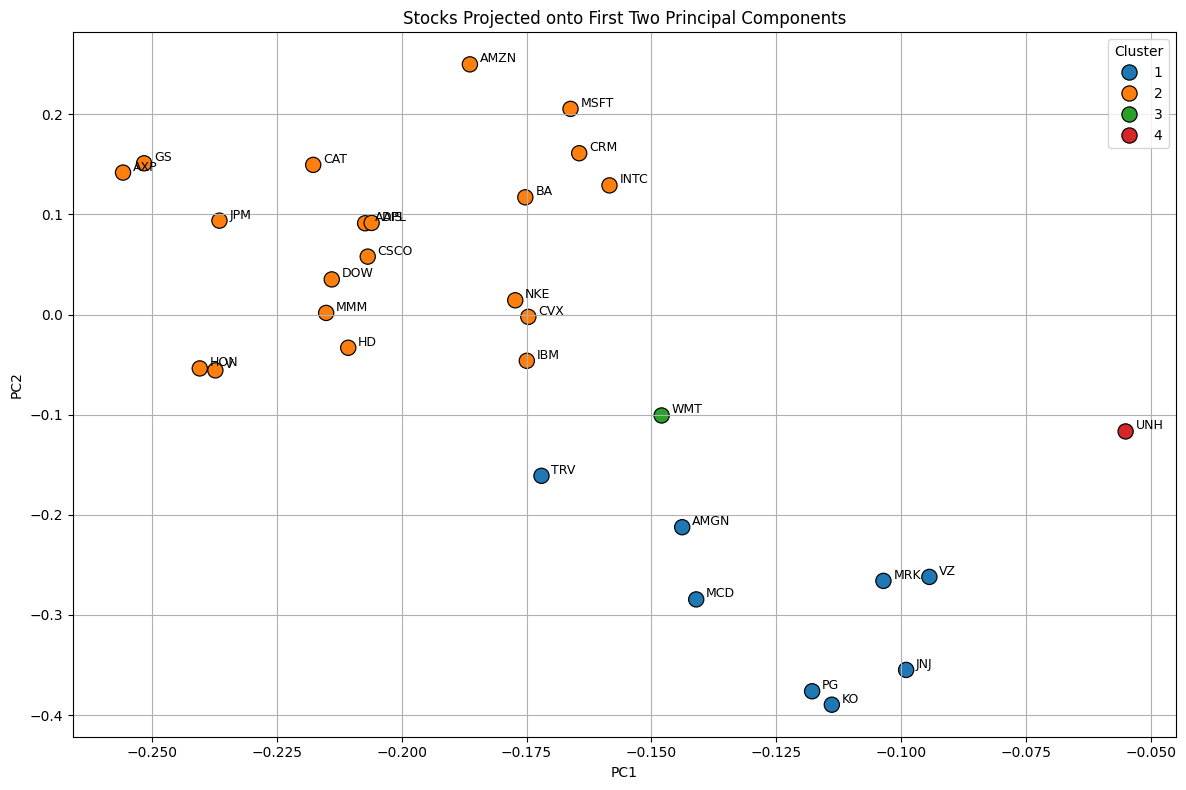

In [74]:
#  Compute PC scores from loadings 
pc_scores = loadings[["PC1", "PC2"]].copy()

# Move index (tickers) into a column
pc_scores = pc_scores.reset_index()
pc_scores = pc_scores.rename(columns={"index": "Ticker"})

cluster_rows = []
for cid, tickers in clean_clusters.items():
    for t in tickers:
        cluster_rows.append({"Ticker": t, "Cluster": cid})

cluster_df = pd.DataFrame(cluster_rows)

# Merge PC scores with cluster labels ---
final_df = pc_scores.merge(cluster_df, on="Ticker", how="left")

# Plot PC1 vs PC2 ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=final_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="tab10",
    s=120,
    edgecolor="black"
)

# Add stock labels 
for _, row in final_df.iterrows():
    plt.text(
        row["PC1"] + 0.002,
        row["PC2"] + 0.002,
        row["Ticker"],
        fontsize=9
    )

plt.title("Stocks Projected onto First Two Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
# List clusters and their stocks
for cluster_id, stocks in clean_clusters.items():
    print(f"Cluster {cluster_id} ({len(stocks)} stocks):")
    print(", ".join(stocks))
    print()

Cluster 2 (20 stocks):
AAPL, AMZN, AXP, BA, CAT, CRM, CSCO, CVX, DIS, DOW, GS, HD, HON, IBM, INTC, JPM, MMM, MSFT, NKE, V

Cluster 1 (8 stocks):
AMGN, JNJ, KO, MCD, MRK, PG, TRV, VZ

Cluster 4 (1 stocks):
UNH

Cluster 3 (1 stocks):
WMT



## Part 3.1

C:\Users\mitch\AppData\Local\Temp\ipykernel_32728\3039306636.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("PG", start="1985-01-01", end=None)["Close"]
[*********************100%***********************]  1 of 1 completed


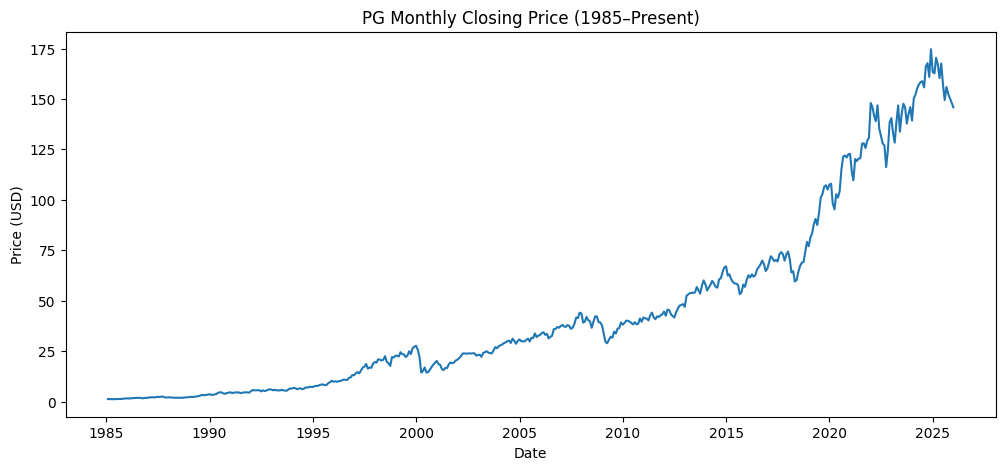

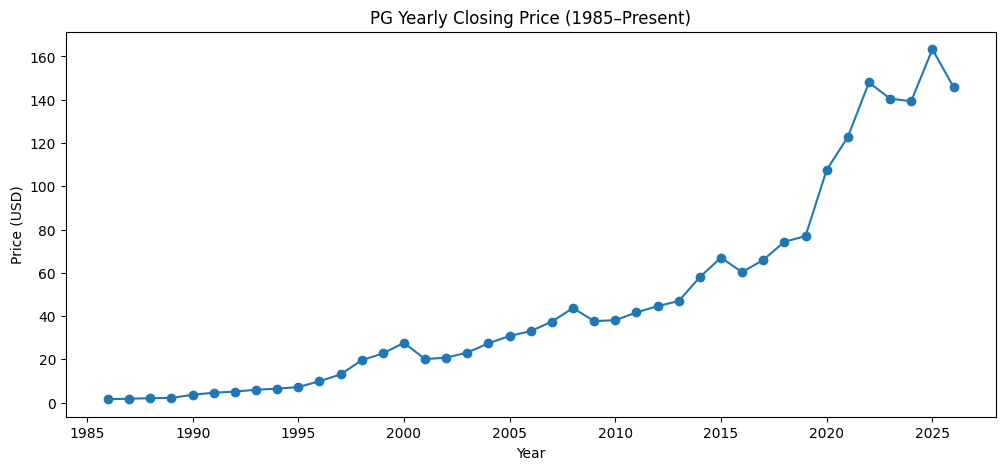

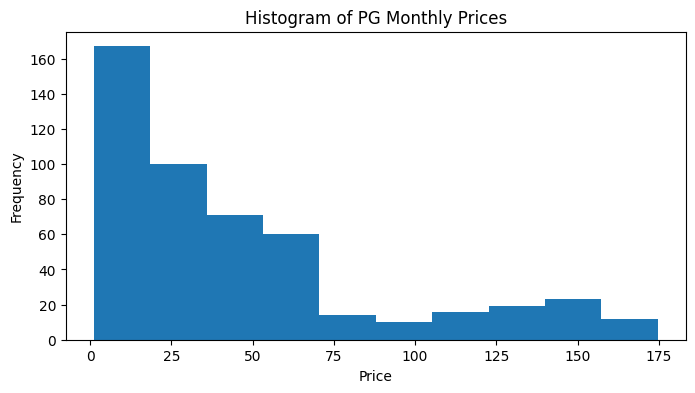

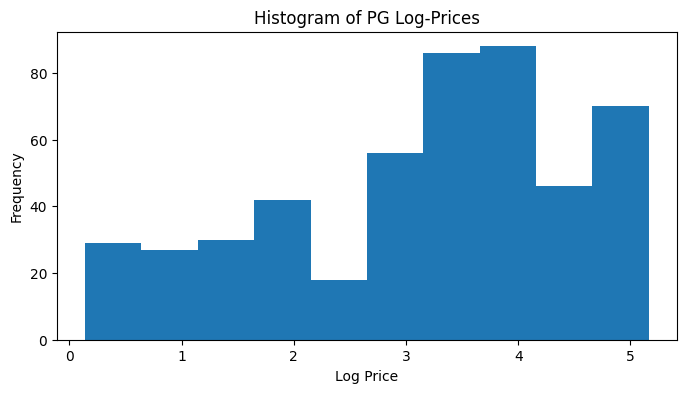

Monthly data:
 Date
1985-01-31    1.226703
1985-02-28    1.240333
1985-03-31    1.210346
1985-04-30    1.151030
1985-05-31    1.189673
Freq: ME, Name: PG, dtype: float64 

Yearly data:
 Date
1985-12-31    1.575650
1986-12-31    1.790124
1987-12-31    2.063811
1988-12-31    2.178326
1989-12-31    3.632927
Freq: YE-DEC, Name: PG, dtype: float64 



In [76]:

data = yf.download("PG", start="1985-01-01", end=None)["Close"]
# 1. Identify oldest Dow component
oldest = "PG"   # Procter & Gamble is the oldest company in the Dow 30

# Extract daily prices from your dataset (Jan 2023 → present)
df_daily = data[oldest]

# Convert to monthly closing prices
df_monthly = df_daily.resample("ME").last().dropna()

log_price = np.log(df_monthly)
monthly_returns = log_price.diff().dropna()

# 2. Monthly line plot
plt.figure(figsize=(12,5))
plt.plot(df_monthly.index, df_monthly.values)
plt.title("PG Monthly Closing Price (1985–Present)")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.show()

# 3. Yearly line plot (aggregate to yearly closes)
df_yearly = df_daily.resample("YE").last()

plt.figure(figsize=(12,5))
plt.plot(df_yearly.index, df_yearly.values, marker="o")
plt.title("PG Yearly Closing Price (1985–Present)")
plt.ylabel("Price (USD)")
plt.xlabel("Year")
plt.show()

# 4. Histogram of prices
plt.figure(figsize=(8,4))
plt.hist(df_monthly.values, bins=10)
plt.title("Histogram of PG Monthly Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# 5. Histogram of log-prices
plt.figure(figsize=(8,4))
plt.hist(log_price.values, bins=10)
plt.title("Histogram of PG Log-Prices")
plt.xlabel("Log Price")
plt.ylabel("Frequency")
plt.show()

# 6. Preview the transformed data
print("Monthly data:\n", df_monthly.head(), "\n")
print("Yearly data:\n", df_yearly.head(), "\n")

In [77]:
# Monthly closing prices for PG
pg_monthly = data['PG'].resample('ME').last().dropna()

# Take log prices (stabilizes variance)
log_pg = np.log(pg_monthly)

# Perform ADF test on log prices
result = adfuller(log_pg)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"  {key}: {value}")

ADF Statistic: -2.0318078559746864
p-value: 0.27280291140955293
Critical Values:
  1%: -3.4437386290417082
  5%: -2.867444458865948
  10%: -2.5699148492415413


**ADF statistic (-2.049) is greater than all critical values (-3.443, -2.867, -2.569) so we fail to reject the null Hypothesis**

**p-value = 0.265 > 0.05**

**The log-price series of PG is non-stationary**

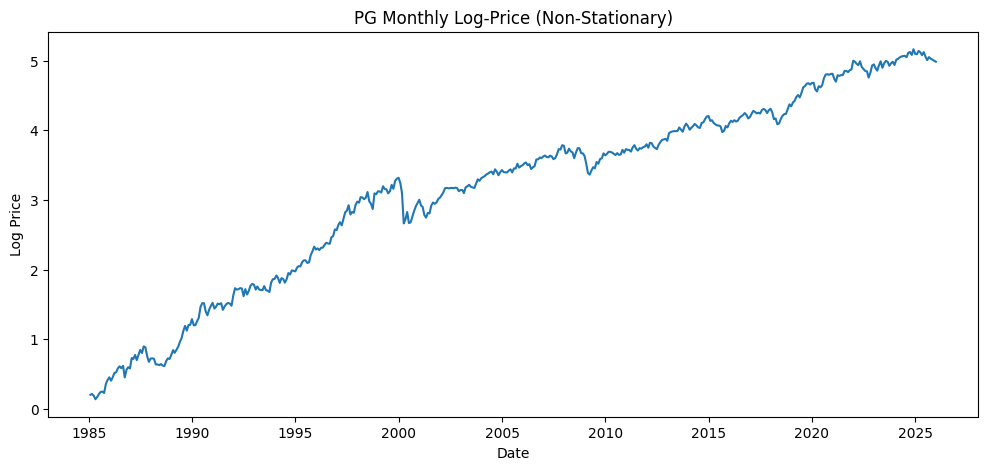

In [78]:
plt.figure(figsize=(12,5))
plt.plot(log_pg)
plt.title("PG Monthly Log-Price (Non-Stationary)")
plt.xlabel("Date")
plt.ylabel("Log Price")
plt.show()

In [79]:
log_pg_diff = log_pg.diff().dropna() # First difference of log prices


In [80]:
# Perform ADF test on first difference
result_diff = adfuller(log_pg_diff)
print("ADF Statistic (1st difference):", result_diff[0])
print("p-value:", result_diff[1])
print("Critical Values:")
for key, value in result_diff[4].items():
    print(f"  {key}: {value}")

ADF Statistic (1st difference): -22.482300847114992
p-value: 0.0
Critical Values:
  1%: -3.4437660979098843
  5%: -2.8674565460819896
  10%: -2.569921291128696


**ADF (-22.47) < all critical values so we reject the null Hypothesis**

**p-value = 0.000 < 0.05 so we reject null hypothesis**

**The series is now stationary**

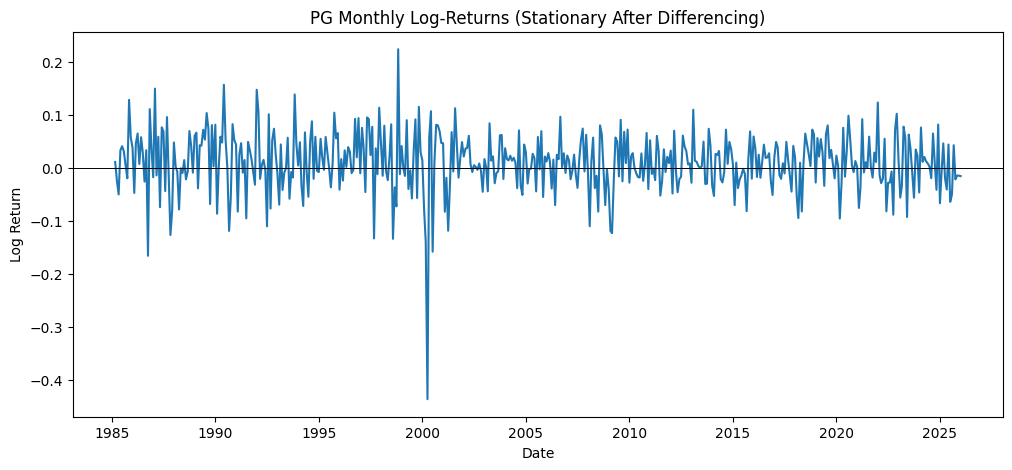

In [81]:
plt.figure(figsize=(12,5))
plt.plot(log_pg_diff)
plt.title("PG Monthly Log-Returns (Stationary After Differencing)")
plt.axhline(0, color='k', linewidth=0.7)
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

## Part 3.2

In [82]:
np.isfinite(pg_monthly).sum(), len(pg_monthly)

(np.int64(492), 492)

<Figure size 1200x400 with 0 Axes>

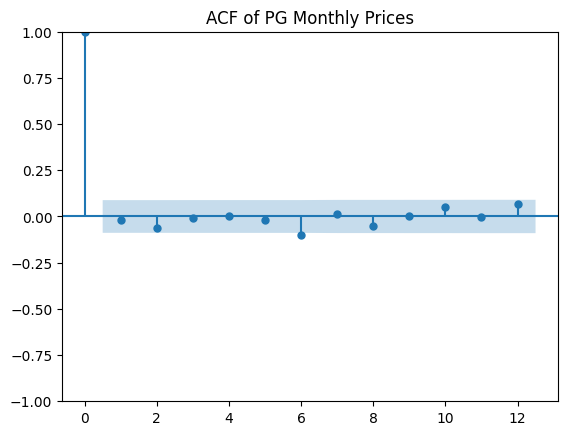

<Figure size 1200x400 with 0 Axes>

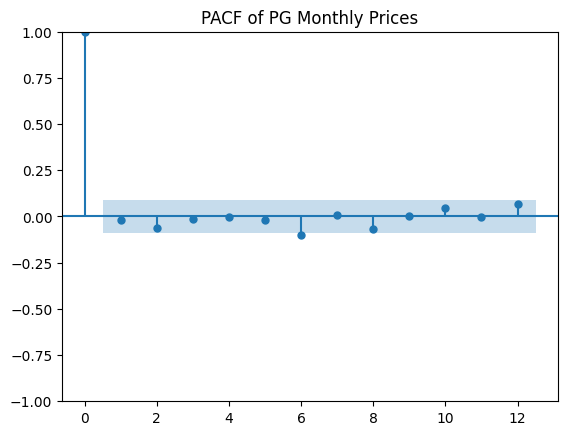

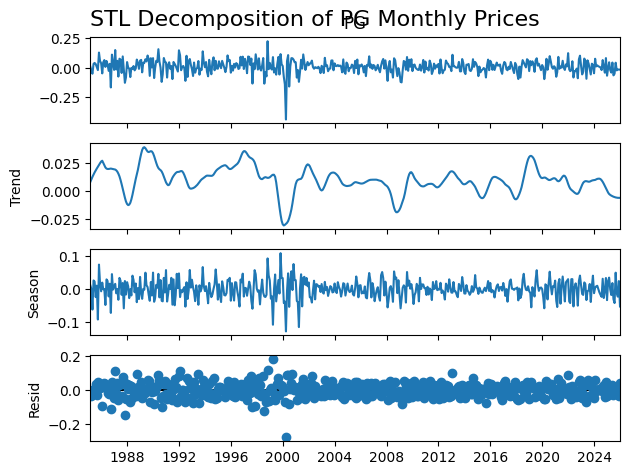

In [83]:
plt.figure(figsize=(12,4))
plot_acf(log_pg_diff, lags=12)
plt.title("ACF of PG Monthly Prices")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(log_pg_diff, lags=12, method='ywm')
plt.title("PACF of PG Monthly Prices")
plt.show()

# STL decomposition
stl = STL(log_pg_diff, period=12)
res = stl.fit()

res.plot()
plt.suptitle("STL Decomposition of PG Monthly Prices", fontsize=16)
plt.show()

## Part 3.3

In [84]:
data = yf.download("PG", start="1985-01-01", end=None)["Close"]

# Extract PG monthly series
pg_monthly = data['PG'].resample('ME').last().dropna()


C:\Users\mitch\AppData\Local\Temp\ipykernel_32728\3118609446.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("PG", start="1985-01-01", end=None)["Close"]
[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'PG Monthly Prices – Last 3 Years'}, xlabel='Date'>

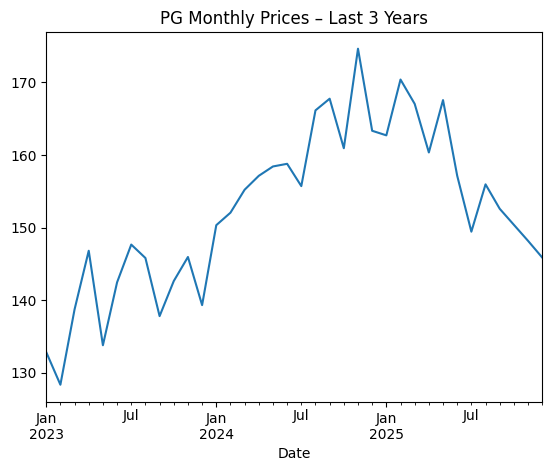

In [85]:
# Select the last 3 years for evaluation

pg_eval = pg_monthly.iloc[-36:]  # last 36 observations
pg_eval.plot(title="PG Monthly Prices – Last 3 Years")

**Simple Moving Average (SMA) Forecasting**

In [86]:
test_period = 36  # Last 12 months for testing
train = pg_monthly.iloc[:-test_period]
test = pg_monthly.iloc[-test_period:]

In [87]:
window = 3  # 3-month moving average

test_df = pd.DataFrame(test)
test_df['3_Month_SMA'] = test_df['PG'].rolling(window=3).mean()

test_df = test_df.dropna()
sma_forecast = test_df['3_Month_SMA']
sma_forecast

Date
2023-03-31    133.286367
2023-04-30    137.944249
2023-05-31    139.757818
2023-06-30    141.001678
2023-07-31    141.284785
2023-08-31    145.293879
2023-09-30    143.741547
2023-10-31    142.065435
2023-11-30    142.112335
2023-12-31    142.617681
2024-01-31    145.185043
2024-02-29    147.220520
2024-03-31    152.523168
2024-04-30    154.791524
2024-05-31    156.915955
2024-06-30    158.106878
2024-07-31    157.634109
2024-08-31    160.211675
2024-09-30    163.203242
2024-10-31    164.943812
2024-11-30    167.776535
2024-12-31    166.302923
2025-01-31    166.894679
2025-02-28    165.478760
2025-03-31    166.715800
2025-04-30    165.929469
2025-05-31    164.984873
2025-06-30    161.682612
2025-07-31    158.042796
2025-08-31    154.171178
2025-09-30    152.652507
2025-10-31    152.967478
2025-11-30    150.370997
2025-12-31    148.130000
Freq: ME, Name: 3_Month_SMA, dtype: float64

In [101]:
window = 3
forecast_horizon = len(test_df)  # or any number of months you want to forecast

# Initialize history with the last `window` points from training
history = list(test_df['PG'][-window:])
forecast = []

# Generate forecasts
for t in range(forecast_horizon):
    next_pred = sum(history[-window:]) / window
    forecast.append(next_pred)
    history.append(next_pred)

# Put forecasts into a DataFrame aligned with the test set

test_df['3_Month_SMA'] = forecast

sma_forecast = test_df['3_Month_SMA']
print(sma_forecast)

Date
2023-03-31    148.130000
2023-04-30    147.383335
2023-05-31    147.124445
2023-06-30    147.545927
2023-07-31    147.351235
2023-08-31    147.340536
2023-09-30    147.412566
2023-10-31    147.368112
2023-11-30    147.373738
2023-12-31    147.384805
2024-01-31    147.375552
2024-02-29    147.378032
2024-03-31    147.379463
2024-04-30    147.377682
2024-05-31    147.378392
2024-06-30    147.378512
2024-07-31    147.378196
2024-08-31    147.378367
2024-09-30    147.378358
2024-10-31    147.378307
2024-11-30    147.378344
2024-12-31    147.378336
2025-01-31    147.378329
2025-02-28    147.378337
2025-03-31    147.378334
2025-04-30    147.378333
2025-05-31    147.378335
2025-06-30    147.378334
2025-07-31    147.378334
2025-08-31    147.378334
2025-09-30    147.378334
2025-10-31    147.378334
2025-11-30    147.378334
2025-12-31    147.378334
Freq: ME, Name: 3_Month_SMA, dtype: float64


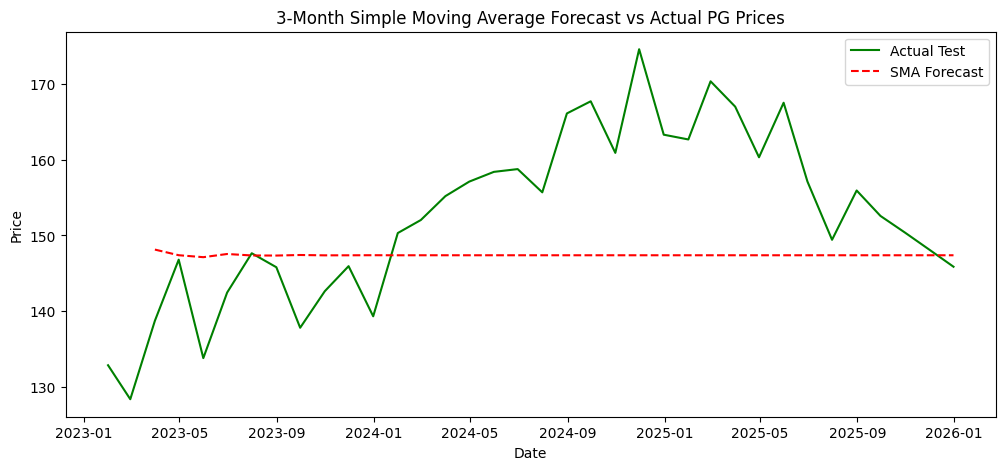

In [102]:
plt.figure(figsize=(12,5))

# plt.plot(train.index, train, label='Training')

plt.plot(test.index, test, label='Actual Test', color='green')

# Plot SMA only starting from where it exists
plt.plot(sma_forecast.index, sma_forecast, 
         label='SMA Forecast', color='red', linestyle='--')

plt.title("3-Month Simple Moving Average Forecast vs Actual PG Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

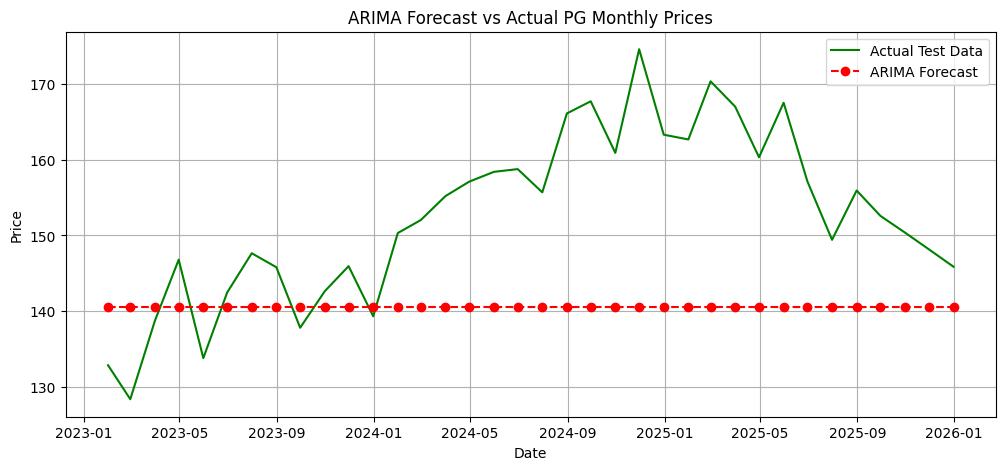

In [90]:
p, d, q = 0, 1, 0
model_arima = ARIMA(np.log(train), order=(p,d,q))
model_arima_fit = model_arima.fit()

forecast_arima = model_arima_fit.forecast(steps=len(test))

forecast_arima = np.exp(forecast_arima) 
# forecast_arima = np.exp(forecast_arima)  # Inverse log transform

plt.figure(figsize=(12,5))
# plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test Data', color='green')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', color='red', linestyle='--', marker='o')
plt.title("ARIMA Forecast vs Actual PG Monthly Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))

# Prepare sequences for LSTM
look_back = 10  # months
X_train, y_train = [], []
for i in range(len(train_scaled)-look_back):
    X_train.append(train_scaled[i:i+look_back, 0])
    y_train.append(train_scaled[i+look_back, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=200, verbose=0)

# Forecast using a rolling approach
lstm_forecast_scaled = []
last_sequence = train_scaled[-look_back:].reshape(1, look_back,1)
for i in range(len(test)):
    pred = model.predict(last_sequence)
    lstm_forecast_scaled.append(pred[0,0])
    # update sequence for next step
    pred_reshaped = pred.reshape((1,1,1))  # reshape to 3D
    last_sequence = np.concatenate((last_sequence[:,1:,:], pred_reshaped), axis=1)

# Inverse scale
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast_scaled).reshape(-1,1))



c:\Users\mitch\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

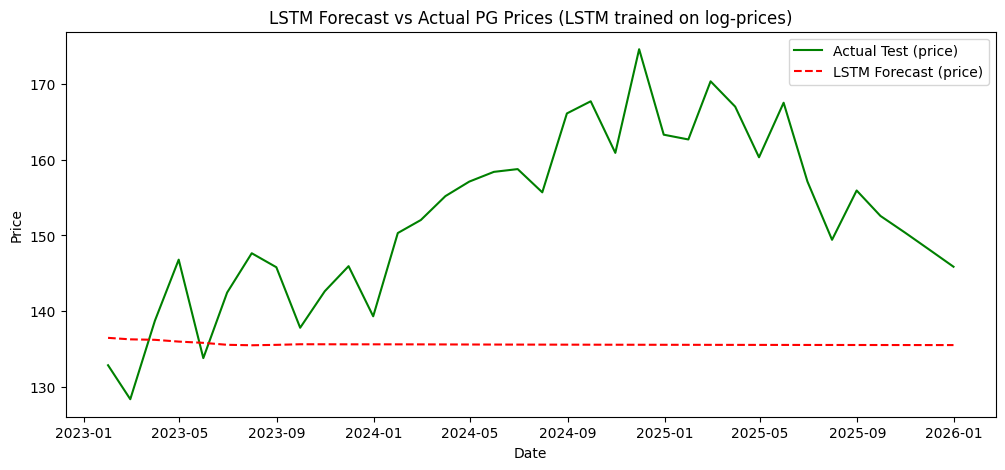

In [92]:
plt.figure(figsize=(12,5))
# plt.plot(train.index, train, label='Training (price)')
plt.plot(test.index, test, label='Actual Test (price)', color='green')
plt.plot(test.index, lstm_forecast, label='LSTM Forecast (price)', color='red', linestyle='--')
plt.title("LSTM Forecast vs Actual PG Prices (LSTM trained on log-prices)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [111]:
forecast_arima_df = pd.DataFrame(forecast_arima)
forecast_arima_df = forecast_arima_df.iloc[2:]

In [110]:
forecast_lstm_df = pd.DataFrame(lstm_forecast)
forecast_lstm_df = forecast_lstm_df.iloc[2:]

In [109]:
test_df['forecast_arima'] = forecast_arima_df.values
test_df['forecast_lstm'] = forecast_lstm_df.values

In [103]:


# Compute error metrics
error_df = pd.DataFrame({
    'Model': ['SMA', 'ARIMA', 'LSTM'],
    'MAE': [
        mean_absolute_error(test_df['PG'], test_df['3_Month_SMA']),
        mean_absolute_error(test_df['PG'], test_df['forecast_arima']),
        mean_absolute_error(test_df['PG'], test_df['forecast_lstm'])
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(test_df['PG'], test_df['3_Month_SMA'])),
        np.sqrt(mean_squared_error(test_df['PG'], test_df['forecast_arima'])),
        np.sqrt(mean_squared_error(test_df['PG'], test_df['forecast_lstm']))
    ]
})

error_df

,Model,MAE,RMSE
0,SMA,9.650665,11.974152
1,ARIMA,14.014332,16.686695
2,LSTM,18.329011,20.853464


In [104]:
forecast_df = test_df.copy()

# Forecast next 12 months using 3-month rolling SMA
window = 3
last_values = forecast_df['PG'].iloc[-window:].tolist()  # last 3 actual values

forecast_values = []
for i in range(12):
    # Compute SMA of last 'window' values
    next_value = sum(last_values[-window:]) / window
    forecast_values.append(next_value)
    last_values.append(next_value)  # append for rolling calculation

# Create datetime index for next 12 months
next_12_months = pd.date_range(start=forecast_df.index[-1] + pd.offsets.MonthBegin(),
                               periods=12, freq='MS')

# Convert forecast into a Series and add to the dataframe
sma_forecast_next_year = pd.Series(forecast_values, index=next_12_months, name='3_Month_SMA_Forecast')
forecast_df = pd.concat([forecast_df, sma_forecast_next_year], axis=1)

forecast_df = forecast_df.drop(columns=['forecast_arima', 'forecast_lstm'])
forecast_df.tail(15)  # Show last 15 rows including the forecast

,PG,3_Month_SMA,3_Month_SMA_Forecast
2025-10-31,150.369995,147.378334,NaN
2025-11-30,148.160004,147.378334,NaN
2025-12-31,145.860001,147.378334,NaN
2026-01-01,NaN,NaN,148.130000
2026-02-01,NaN,NaN,147.383335
2026-03-01,NaN,NaN,147.124445
2026-04-01,NaN,NaN,147.545927
2026-05-01,NaN,NaN,147.351235
2026-06-01,NaN,NaN,147.340536
2026-07-01,NaN,NaN,147.412566


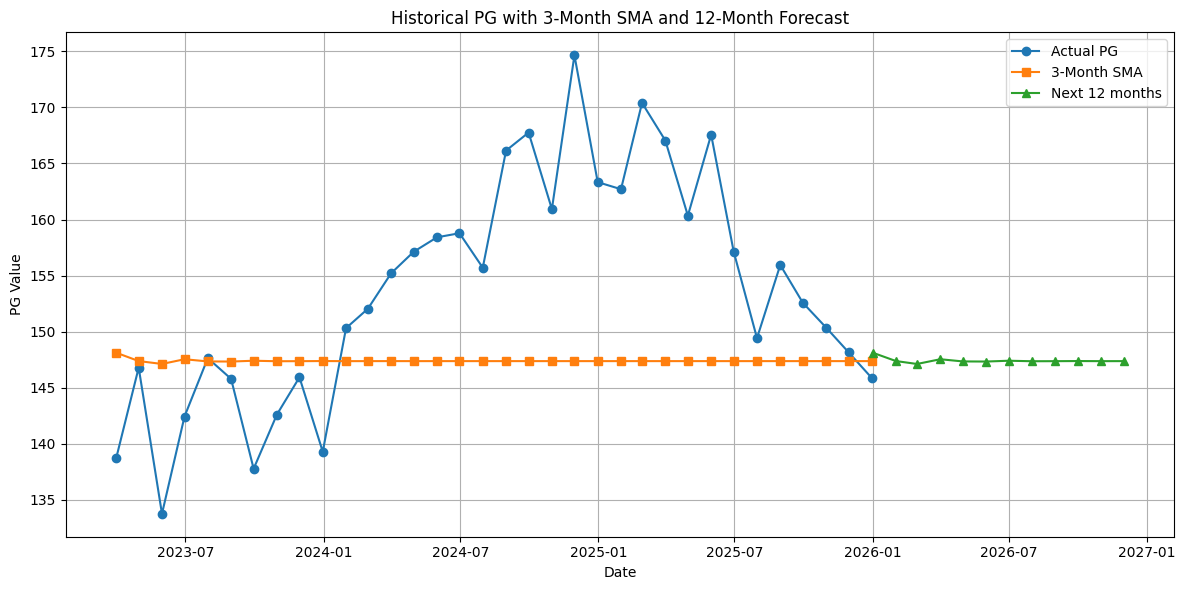

In [105]:
plt.figure(figsize=(12,6))

# Plot historical actual values
plt.plot(forecast_df.index, forecast_df['PG'], label='Actual PG', marker='o')

# Plot existing 3-month SMA
plt.plot(forecast_df.index, forecast_df['3_Month_SMA'], label='3-Month SMA', marker='s')

# Plot 12-month SMA forecast
plt.plot(forecast_df.index, forecast_df['3_Month_SMA_Forecast'], label='Next 12 months', marker='^')

plt.xlabel('Date')
plt.ylabel('PG Value')
plt.title('Historical PG with 3-Month SMA and 12-Month Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()